# 0. Import packages

## 0.1. Clear the workspace

In [1]:
# Clear all variables in the workspace
%reset -f

## 0.2. Ubermag

In [2]:
import oommfc as oc
oc.runner.runner

TclOOMMFRunner(/Applications/oommf/oommf/oommf.tcl)

In [3]:
import discretisedfield as df
import micromagneticmodel as mm

## 0.3. My custom modules

In [4]:
import custom_image_processing as cip
import custom_system_properties as csp
import custom_temporal_field_tcl_scripts as ctf
import convert_field_units

## 0.4. General Python

In [5]:
%matplotlib inline
from dataclasses import dataclass
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Define the overall system

Set your data and figure output directories; used for saving the simulation data and figures, respectively. The `json_params` dictionary is used to store parameters that will be passed to the JSON file.

In [6]:
data_output = '/Users/cameronmceleney/Data/2025-04-10/Ubermag_data'
figs_output = '/Users/cameronmceleney/Data/2025-04-10/Ubermag_output'

json_params = {}

## 1.1. Container

- `system.name` will be used extensively for naming output files and figures. Ensure it is descriptive and key-search friendly.
- Assume there is no temperature `T` to consider.

In [7]:
system = mm.System(name='alban_switch',
                   T=0)

I prefer to use my own custom system properties class as this allows me to define dimensions, cell sizes, and other properties in a single place prior to declaring any region (`df.Region`) or mesh (`df.Mesh`) instances. For me, `csp.SystemProperties` improve code readability.

> To only use functionality defined by Ubermag one must first define a mesh and then a region. The dimensions can be extracted from either, while the cell size is a property of the mesh.

The `buffer_width` is the only parameter required to define the non-magnetic space between the two spin chain regions.

In [8]:
# System dimensions
system_prop = csp.SystemProperties(length=4000e-9,
                                   width=1e-9,
                                   thickness=20e-9)

# System mesh cell size
system_prop.cell = (1e-9, 1e-9, 4e-9)
system_prop.units = ('m', 'm', 'm')
system_prop.update_numcells()

# Buffer dimensions
buffer_width = 12e-9  # [m]

## 1.2. Primary region
This model will consistent of a primary region that is subdivided into three subregions. First, we set up the container for the primary region.

> The command `%%capture` is a Jupyter magic command that suppresses the output of the cell. Comment it out to see the cell's output.

In [9]:
%%capture
domain = csp.MyRegions(system.name + "_regions");

Now we define the primary region. I follow the convention of naming the primary region's `df.Region` "main" *i.e.* `domain.main` in this instance.

In [10]:
%%capture
domain.main(p1=(-system_prop.length / 2, 0, 0),
            p2=(+system_prop.length / 2,
                system_prop.width,
                system_prop.thickness),
            dims=('x', 'y', 'z')
)

### 1.2.1. Material subregions
One could solely use the `domain` container we just created to also hold these subregions. For demonstration purposes more than anything else, we first create a second, separate container for the subregions.

- The left and right subregions will be identical save for their starting magnetisation orientation. One will have `m_init_left = (0,0,-1)` while the other has `m_init_right = (0,0,1)`.
- The central subregion will be a buffer region wherein the saturation magnetisation $M_{s}$ is zero.

In [11]:
%%capture
subdomains = csp.MyRegions(system.name + "_subregions")

Either way, now we can define the subregions.

In [12]:
%%capture
subdomains.materialBottom(p1=domain.main.pmin,
                          p2=(domain.main.pmax[0],
                              domain.main.pmax[1],
                              system_prop.cell[2]),
                          dims=('x', 'y', 'z')
                          )

subdomains.buffer(p1=(domain.main.pmin[0],
                      domain.main.pmin[1],
                      subdomains.materialBottom.pmax[2]),
                  p2=(domain.main.pmax[0],
                      domain.main.pmax[1],
                      subdomains.materialBottom.pmax[2] + buffer_width),
                  dims=('x', 'y', 'z')
                  )

subdomains.materialTop(p1=(domain.main.pmin[0],
                           domain.main.pmin[1],
                           subdomains.buffer.pmax[2]),
                       p2=domain.main.pmax,
                       dims=('x', 'y', 'z')
                       )

## 1.3. Define the overall mesh

In [13]:
%%capture
domain.mesh = df.Mesh(region=domain.main.region,
                      cell=system_prop.cell,
                      bc='x',  # periodic 'Boundary Conditions'
                      subregions=subdomains.subregions)

It's always a good idea to check that the mesh has been created correctly. The `mpl` method of the mesh object allows us to visualise the mesh and subregions. Note that the proportions of the mesh may not be accurately represented in the plot. The `box_aspect` argument can be tweaked as required to improve the visualisation.

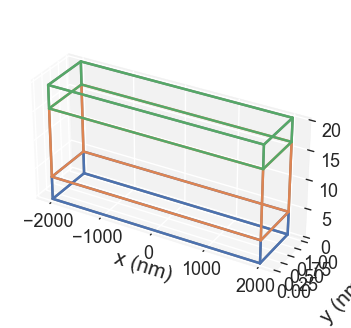

In [14]:
domain.mesh.mpl.subregions(figsize=(4, 4),
                           multiplier=1e-9,  # Scale the axis labels to nanometres
                           box_aspect=(8, 2, 4),
                           show_region=True
                           )

# 2. Define the system's starting magnetisation state

## 2.1. Saturisation magnetisation, $M_{s}$

In [15]:
sat_mag = 8e5  # [A/m]

## 2.2. Create a mask for the magnetisation of the primary region

Create a mask for the primary region. Cells where $M_{s} = 0$ will be treated as non-magnetic **only if** we pass `valid='norm'` as an argument when defining `system.m`.

If `valid='norm'` is not used, then we must ensure that all other definitions, such as the regions defining $\mathbf{m}_\text{0}$ **exactly** match those used in the mask for $M_{s}$. In this example, failure to do so would lead to cells being initialised with unnormalised magnetisations. This almost always leads to garbage, and can be a very subtle error to debug.

In [16]:
def sat_mag_func(pos):
    valid_regions = [subdomains.materialBottom.region, subdomains.materialTop.region]

    if any(pos in region for region in valid_regions):
        return sat_mag
    else:
        return 0.0

## 2.3. Initial magnetisation, $\mathbf{m}_{0}$

In [17]:
def m_init_func(pos):
    if pos in subdomains.materialBottom.region:
        return (0.0, 0.0, 1.0)
    elif pos in subdomains.materialTop.region:
        return (0.0, 0.0, -1.0)
    else:
        return (0.0, 0.0, 0.0)

## 2.4. Create the system's magnetisation field

In [18]:
system.m = df.Field(
    mesh=domain.mesh,
    value=m_init_func,
    norm=sat_mag_func,
    valid='norm',
    nvdim=3
)

# 3. Define the energy equation

In [19]:
@dataclass
class EnableEnergyTerm:
    anisotropy: bool = False
    demag: bool = False
    dmi: bool = False
    driving_zeeman: bool = False
    exchange: bool = False
    static_zeeman: bool = False

In [20]:
system.energy = 0

## 3.1. Quick access

Not yet implemented. You can use `has_energy.__dict__` to print possible flags.

In [21]:
has_energy = EnableEnergyTerm()

## 3.2. Static Zeeman field

In [22]:
system.energy += mm.Zeeman(
    H = {'materialBottom': (0, 0, 0.15),
         'buffer': (0.0, 0.0, 0.0),
         'materialTop': (0, 0, -0.15)
         }
)

convert_field_units.ampere_per_metre(system.energy)

## 3.3. Heisenberg exchange interaction

In [23]:
exchange_stiffness = 1.3e-11

system.energy += mm.Exchange(
    A = {'materialBottom': exchange_stiffness,
         'buffer': 0,
         'materialTop': exchange_stiffness
         }
)

In [24]:
exchange_length = np.sqrt(
    (2 * system.energy.exchange.A['materialBottom'])/ (mm.consts.mu0 * sat_mag ** 2)
)

print(f"Exchange length: {exchange_length * 1e9:.2f} nm")

if exchange_length < system_prop.cell[0] * 5:
    raise ValueError('Exchange length is less than five times the cell size!')

Exchange length: 5.69 nm


## 3.4. Dipole-dipole coupling

In [25]:
#system.energy += mm.Demag(
#    asymptotic_radius=16
#)

## 3.5. Dynamic Zeeman field

In [31]:
driving_field_strength = (1e-3, 0, 0)  # [T]
driving_region_width = 200e-9  # [m]

In [ ]:
zeeman_drive_base = convert_field_units.ampere_per_metre(list(driving_field_strength))

In [32]:
json_params['h0_x [A/m]'] = str(driving_field_strength[0])
json_params['h0_y [A/m]'] = str(driving_field_strength[1])
json_params['h0_z [A/m]'] = str(driving_field_strength[2])

(795.7747154594767, 0.0, 0.0)


Next, we need to define where the line antennae are positioned. It's easiest to continue working with the `subdomains` container.

In [114]:
%%capture
subdomains.antennaBottom(
    p1=(-driving_region_width / 2,
        subdomains.materialBottom.pmin[1],
        subdomains.materialBottom.pmin[2]),
    p2=(+driving_region_width / 2,
        subdomains.materialBottom.pmax[1],
        subdomains.materialBottom.pmax[2]
        )
)

subdomains.antennaTop(
    p1=(-driving_region_width / 2,
        subdomains.materialTop.pmin[1],
        subdomains.materialTop.pmin[2]),
    p2=(+driving_region_width / 2,
        subdomains.materialTop.pmax[1],
        subdomains.materialTop.pmax[2]
        )
)

Update meshes, and print new mesh to visually check change(s).

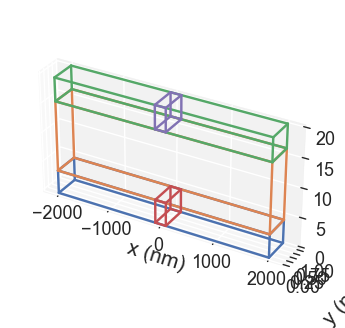

In [115]:
domain.mesh.subregions = subdomains.subregions
system.m.mesh.subregions = domain.mesh.subregions

domain.mesh.mpl.subregions(figsize=(4, 4),
                           multiplier=1e-9,
                           box_aspect=(8, 1, 4),
                           show_region=False)

### 3.5.1. Strength of the driving field

For true control over the implementation of $\mathbf{h}_\text{d}$ we must define a customised field (`df.Field`). This determines whether a cell is located in a driven region.

In [116]:
def in_driven_region(pos):
    driven_regions = [subdomains.antennaBottom.region, subdomains.antennaTop.region]

    if any(pos in region for region in driven_regions):
        return True
    else:
        return False

def driven_strength_func(pos):
    if in_driven_region(pos):
        return driving_field_strength
    else:
        return (0.0, 0.0, 0.0)

We can now create a field for $\mathbf{h}_\text{d}$, and add it to the respective energy term.

In [117]:
zeeman_drive_field = df.Field(
    mesh=domain.mesh,
    value=driven_strength_func,
    nvdim=3
)

If you are using `tcl_strings` then you **must** ensure that `mm.Zeeman.name` is identical to the name passed to the tcl script.

In [118]:
energy_zeeman_drive = mm.Zeeman(
    name='drive',
    H=zeeman_drive_field,
    tcl_strings=ctf.drive_pause_drive_rotate_counterclockwise('drive'),
)

## 3.6. Check our energy equation

In [119]:
system.energy

Zeeman(H={'materialBottom': (0.0, 0.0, 119366.2073189215), 'buffer': (0.0, 0.0, 0.0), 'materialTop': (0.0, 0.0, -119366.2073189215)}) + Exchange(A={'materialBottom': 1.3e-11, 'buffer': 0, 'materialTop': 1.3e-11})

# 4. Define the dynamics equation

## 4.1. Gilbert damping

In [1264]:
alpha_bulk = 0.01
alpha_driven = 0.01
alpha_interfacial = 0.01

In [1265]:
json_params['alpha_bulk'] = str(alpha_bulk)
json_params['alpha_driven'] = str(alpha_driven)
json_params['alpha_interfacial'] = str(alpha_interfacial)

In [1266]:
#alpha_func = dar.AlphaABC(
#    alpha_bulk=alpha_bulk,
#    alpha_driven=alpha_driven,
#    system_prop=system_prop,
#    system_subregions=subdomains)

In [1267]:
system.dynamics += mm.Damping(alpha=alpha_bulk)

## 4.2. Precession

Gyromagnetic ratio, $\gamma_{0}$

In [1268]:
gamma0 = 28.2e9 * 2 * np.pi  # [rad*Hz/T]

In [1269]:
system.dynamics += mm.Precession(gamma0=gamma0*mm.consts.mu0)

## 4.3. Check our expression

In [1270]:
system.dynamics

Damping(alpha=0.01) + Precession(gamma0=222658.2752885759)

# 5. Relaxation

## 5.1. Drive the system

### 5.1.1. Define the minimisation evolver

In [1271]:
min_evolver = oc.CGEvolver(
    method='Polak-Ribiere',
    #energy_precision=1e-10  # May need to increase for large systems
)

minD = oc.MinDriver(
    evolver=min_evolver,
    stopping_mxHxm=0.1
)

### 5.1.2. Apply the `TimeDriver`

In [1272]:
minD.drive(
    system,
    dirname=data_output,
    verbose=2
)

Running OOMMF (TclOOMMFRunner)[2025/04/10 21:15]... (0.6 s)


## 5.2. Display and save the output

In [1273]:
%%capture
cip.default_three_pane(
    system=system,
    system_prop=system_prop,
    system_region=domain,
    figs_output_dir=figs_output,
    drive_number=system.drive_number,
    fig_name='relaxed',
    has_schematic=False,
    #scalar_resample_shape=[256, 3],
    # vector_resample_shape=[16, 3]
)

# 6. Drive the system with the time-dependent field

## 6.1. Set temporal parameters

In [1274]:
tmax = 16e-9  # [s]
stepsize = 1e-12
num_datapoints = 400
stepsize_between_datapoints = tmax / num_datapoints

## 6.2. Add time-dependent fields to the energy equation

In [1275]:
system.energy += energy_zeeman_drive

In [1276]:
system.energy

Zeeman(H={'materialBottom': (0.0, 0.0, 119366.2073189215), 'buffer': (0.0, 0.0, 0.0), 'materialTop': (0.0, 0.0, -119366.2073189215), 'default': (0, 0, 0)}) + Exchange(A={'materialBottom': 1.3e-11, 'buffer': 0, 'materialTop': 1.3e-11}) + Zeeman(H=Field(Mesh(Region(pmin=[-2e-06, 0.0, 0.0], pmax=[2e-06, 1e-09, 2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[4000, 1, 5], bc=x, subregions: (Region`materialBottom`(pmin=[-2e-06, 0.0, 0.0], pmax=[2e-06, 1e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`buffer`(pmin=[-2e-06, 0.0, 4e-09], pmax=[2e-06, 1e-09, 1.6e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`materialTop`(pmin=[-2e-06, 0.0, 1.6e-08], pmax=[2e-06, 1e-09, 2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`antennaBottom`(pmin=[-1e-07, 0.0, 0.0], pmax=[1e-07, 1e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`antennaTop`(pmin=[-1e-07, 0.0, 1.6e-08], pmax=[1e-07, 1e-09, 2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm'

## 6.3. Drive the system



### 6.3.1. Define the evolver

In [1277]:
sim_time_evolver = oc.RungeKuttaEvolver(
    method='rkf54',
    #alpha=alpha,  # Do not supply here if defined in `system.dynamics`
    #gamma_G=gamma0*mm.consts.mu0,
    # Driver may override timestep conditions if stopping_criteria are given
    #min_timestep=0,  # Default: zero.
    #max_timestep=stepsize,  # Default: 1e-10 [s].
    do_precess=1,
    #energy_precision=1e-10,  # May need to increase for large systems
    allow_signed_gamma=0,
)

sim_time_driver = oc.TimeDriver(evolver=sim_time_evolver)

### 6.3.2. Apply the `TimeDriver`

It's at this point we pass our JSON parameters to the driver.

In [1278]:
sim_time_driver.drive(
    system,
    t=tmax,
    dirname=data_output,
    n=num_datapoints,
    n_threads=10,
    verbose=2,
    **json_params
)

Running OOMMF (TclOOMMFRunner):   0%|          | 0/400 files written [00:00]

Running OOMMF (TclOOMMFRunner)[2025/04/10 21:15] took 291.4 s


## 6.4. Display and save the output

/Users/cameronmceleney/PycharmProjects/Ubermag/venv/lib/python3.12/site-packages/matplotlib/quiver.py:630: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/cameronmceleney/PycharmProjects/Ubermag/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


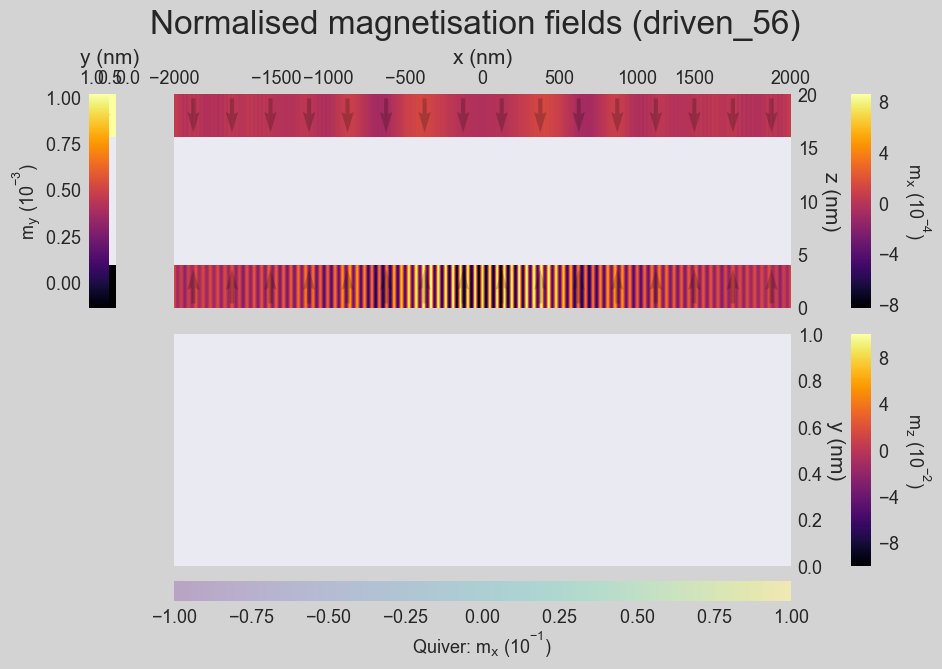

In [1279]:
cip.default_three_pane(
    system,
    system_prop,
    domain,
    figs_output,
    system.drive_number - 1,
    f'driven_{system.drive_number - 1}',
    has_schematic=False)

In [1280]:
raise ValueError("Stop here.")

ValueError: Stop here.

# 7. Post-processing

In [36]:
# Or plot multiple time indices on one plot:
m_all_data = md.Drive(name=system.name, dirname=data_output, number=56, use_cache=True)

## 7.1. Plot the energy components

[Text(0.5, 1.0, 'Drive energy components'), Text(0, 0.5, 'Energy (J)')]

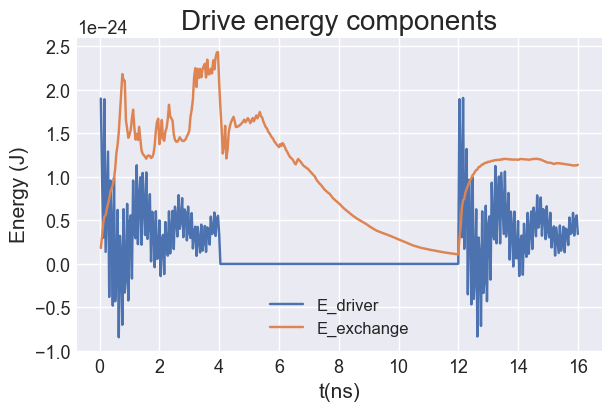

In [133]:
%matplotlib inline
fig, ax = plt.subplots(num=1, figsize=(6, 4), layout='constrained', frameon=True)

m_all_data.table.mpl(ax=ax,
                     x='t',
                     y=['E_driver', 'E_exchange'],
                     multiplier=1e-9
                     )

ax.set(title='Drive energy components',
       ylabel='Energy (J)'
       )

In [1367]:
def compute_drive_data(m_all_data, sat_mag, system_prop, m_pos=None):
    """
    Extract drive data and compute baseline-subtracted profiles.

    Parameters:
      m_all_data : micromagneticdata.Drive
          Drive data object.
      sat_mag : float
          Saturation magnetization.
      system_prop : object
          Must provide attributes: numcells (at least index 0) and cell (tuple).
      m_pos : list or tuple, optional
          Indices for baseline extraction. Default is [0,4] if not provided.

    Returns:
      data_mx, data_my, data_mz : np.ndarray, shape (n_time, n_cells_x)
          Baseline-subtracted profiles.
      baseline : dict
          Contains baseline values (for potential further use).
    """
    data_m0 = m_all_data.m0.to_xarray().values  # shape: (n_time, ..., 3)
    if m_pos is None:
        m_pos = [0, 4]
    baseline_mx = data_m0[:, m_pos[0], m_pos[1], 0] / sat_mag
    baseline_my = data_m0[:, m_pos[0], m_pos[1], 1] / sat_mag
    baseline_mz = data_m0[:, m_pos[0], m_pos[1], 2] / sat_mag

    m_data = m_all_data.to_xarray()  # shape: (n_time, n_cells_x, n_cells_y, n_cells_z, 3)
    n_time = m_all_data.n
    n_cells_x = int(system_prop.numcells[0])
    data_mx = np.zeros((n_time, n_cells_x))
    data_my = np.zeros((n_time, n_cells_x))
    data_mz = np.zeros((n_time, n_cells_x))

    for i in range(n_time):
        data_mx[i] = (m_data[i, :, m_pos[0], m_pos[1], 0].values / sat_mag) - baseline_mx[i]
        data_my[i] = (m_data[i, :, m_pos[0], m_pos[1], 1].values / sat_mag) - baseline_my[i]
        data_mz[i] = (m_data[i, :, m_pos[0], m_pos[1], 2].values / sat_mag) - baseline_mz[i]

    baseline = {'mx': baseline_mx, 'my': baseline_my, 'mz': baseline_mz}
    return data_mx, data_my, data_mz, baseline


def plot_drive_profiles(time_indices, m_all_data, system_prop, sat_mag,
                        figs_output, m_pos=None, quantity='mx',
                        title_prefix="", save_fig=True,
                        file_output_extension=".png",
                        global_ylim=None, global_xlim=None):
    """
    Plots drive profiles for one or more time indices.

    Parameters:
      time_indices : int or list of ints
          Time index (or list) to plot.
      m_all_data : micromagneticdata.Drive
          Drive data object.
      system_prop : object
          Must have attributes: numcells, length, cell.
      sat_mag : float
          Saturation magnetization.
      figs_output : str
          Output directory for figures.
      m_pos : list or tuple, optional
          Baseline extraction cell indices.
      quantity : str, optional
          Which magnetization component ('mx', 'my', or 'mz') to plot.
      title_prefix : str, optional
          Text prepended to the figure title.
      save_fig : bool, optional
          If True, the figure is saved.
      file_output_extension : str, optional
          File extension to use when saving the figure (e.g. ".png", ".jpg").
      global_ylim : tuple or None, optional
          A tuple (ymin, ymax) specifying the y-axis limits. If None no explicit y-limits are set.
      global_xlim : tuple or None, optional
          A tuple (xmin, xmax) specifying the x-axis limits. If None, defaults to (1, system_prop.length*1e9).

    Returns:
      None.
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    if isinstance(time_indices, int):
        time_indices = [time_indices]

    data_mx, data_my, data_mz, baseline = compute_drive_data(m_all_data, sat_mag, system_prop, m_pos)
    cell_x_nm = system_prop.cell[0] / 1e-9  # cell size in nm
    num_cells_x = int(system_prop.numcells[0])
    x = np.arange(0, num_cells_x * cell_x_nm, cell_x_nm)

    n_time = m_all_data.n
    tmax = m_all_data.info.get('t')
    tstep = (tmax / n_time) if tmax is not None else 1.0

    if quantity == 'mx':
        data = data_mx
    elif quantity == 'my':
        data = data_my
    elif quantity == 'mz':
        data = data_mz
    else:
        raise ValueError("quantity must be one of 'mx', 'my', or 'mz'")

    plt.figure(figsize=(8, 5))
    for t_idx in time_indices:
        profile = data[t_idx - 1, :]
        label = f"Time = {t_idx * tstep / 1e-9:.3f} ns"
        plt.plot(x, profile, alpha=0.8, label=label)

    drive_num = m_all_data.info.get('drive_number', 'N/A')
    plt.title(f"{title_prefix} Drive: {drive_num} | {quantity} Profile")
    plt.xlabel('Distance (nm)')
    plt.ylabel('Amplitude (a.u.)')

    # Set x-limits either from the passed global_xlim or default to (1, system_prop.length in nm)
    if global_xlim is not None:
        plt.xlim(global_xlim)
    else:
        plt.xlim(1, system_prop.length * 1e9)

    # Set y-limits if provided.
    if global_ylim is not None:
        plt.ylim(global_ylim)

    plt.legend()

    if save_fig:
        fname = os.path.join(figs_output, f"drive-{m_all_data.number}_profile{file_output_extension}")
        plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()


def create_drive_gif(m_all_data, system_prop, sat_mag, figs_output,
                     time_indices=None, quantity='mx', title_prefix="",
                     gif_filename="drive_profile.gif", fps=10, m_pos=None,
                     global_ylim=None, global_xlim=None):
    """
    Creates a GIF animation of drive profiles for a list of time_indices.

    Parameters:
      m_all_data : micromagneticdata.Drive
          Drive data object.
      system_prop : object
          Must have attributes: numcells, length, cell.
      sat_mag : float
          Saturation magnetization.
      figs_output : str
          Directory in which to save the GIF.
      time_indices : list or None, optional
          A list of time indices (1-indexed). If None, defaults to all time steps with step 10.
      quantity : str, optional
          Which component ('mx', 'my', or 'mz') to plot. Default is 'mx'.
      title_prefix : str, optional
          A title string to prepend to the plot title.
      gif_filename : str, optional
          Filename for the output GIF.
      fps : int, optional
          Frames per second for the GIF.
      m_pos : list or tuple, optional
          Baseline extraction indices.
      global_ylim : tuple or None, optional
          The (ymin, ymax) limits for the y-axis. If None, computed from the data.
      global_xlim : tuple or None, optional
          The (xmin, xmax) limits for the x-axis. If None, defaults to (x[0], x[-1]).

    Returns:
      None. The GIF is saved in the figs_output directory.
    """

    # Default to every 10th time step (1-indexed) if none provided.
    if time_indices is None:
        time_indices = list(np.arange(1, m_all_data.n + 1, 10))
    elif isinstance(time_indices, int):
        time_indices = list(np.arange(1, m_all_data.n + 1, time_indices))


    # Get the baseline-subtracted profiles.
    data_mx, data_my, data_mz, baseline = compute_drive_data(m_all_data, sat_mag, system_prop, m_pos)
    if quantity == 'mx':
        data = data_mx
    elif quantity == 'my':
        data = data_my
    elif quantity == 'mz':
        data = data_mz
    else:
        raise ValueError("quantity must be one of 'mx', 'my', or 'mz'")

    # Compute x-axis positions (in nm) from cell size and numcells.
    cell_x_nm = system_prop.cell[0] / 1e-9
    num_cells_x = int(system_prop.numcells[0])
    x = np.arange(0, num_cells_x * cell_x_nm, cell_x_nm)

    # Determine time step (if available)
    n_time = m_all_data.n
    tmax = m_all_data.info.get('t')
    tstep = (tmax / n_time) if tmax is not None else 1.0

    # Compute global x-limits if not provided.
    if global_xlim is None:
        # Default to the full x-range (here using the leftmost point and the maximum distance)
        global_xlim = (x[0], x[-1])

    # Compute global y-limits if not provided.
    if global_ylim is None:
        # Gather the data for the selected time indices.
        # Note: time_indices are 1-indexed so subtract one.
        sel_data = data[np.array(time_indices) - 1, :]
        # Compute min and max; you might also add a small margin.
        y_min = np.min(sel_data)
        y_max = np.max(sel_data)
        # Optionally, add a 5% margin.
        margin = 0.05 * (y_max - y_min)
        global_ylim = (y_min - margin, y_max + margin)

    temp_dir = os.path.join(figs_output, "temp_frames")
    os.makedirs(temp_dir, exist_ok=True)
    frame_filenames = []

    for t_idx in time_indices:
        plt.figure(figsize=(8, 5))
        profile = data[t_idx - 1, :]
        label = f"Time = {t_idx * tstep / 1e-9:.3f} ns"
        plt.plot(x, profile, alpha=0.8, label=label)
        drive_num = m_all_data.info.get('drive_number', 'N/A')
        plt.title(f"{title_prefix} Drive: {drive_num} | {quantity} Profile")
        plt.xlabel('Distance (nm)')
        plt.ylabel('Amplitude (a.u.)')
        plt.xlim(global_xlim)
        plt.ylim(global_ylim)
        plt.legend(loc='upper right')

        frame_filename = os.path.join(temp_dir, f"frame_{t_idx:04d}.png")
        plt.savefig(frame_filename, dpi=150, bbox_inches='tight')
        plt.close()
        frame_filenames.append(frame_filename)

    # Build the GIF from the stored frames.
    gif_path = os.path.join(figs_output, gif_filename)
    with imageio.get_writer(gif_path, mode='I', fps=fps) as writer:
        for filename in frame_filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Clean up temporary files.
    for filename in frame_filenames:
        os.remove(filename)
    os.rmdir(temp_dir)

    print("GIF created:", gif_path)

In [1285]:
create_drive_gif(m_all_data, system_prop, sat_mag, figs_output, quantity='mx',
                 fps=8,
                 m_pos=[0, 4],
                 time_indices=2,
                 title_prefix="Top |",
                 gif_filename=f"drive-{m_all_data.info.get('drive_number', 'N/A')}_profile_top.gif",
                 global_ylim=[-0.0015, 0.0015])

GIF created: /Users/cameronmceleney/Data/2025-04-10/Ubermag_output/drive-56_profile_top.gif


In [100]:
plot_drive_profiles(
    time_indices=[100, 150, 250, 300, 400],
    m_all_data=m_all_data,
    system_prop=system_prop,
    sat_mag=sat_mag,
    figs_output=figs_output,
    m_pos=[0, 4],
    title_prefix="(Top) Multi-time |",
    file_output_extension='_top.png',
    global_ylim=[-0.0015, 0.0015],
    save_fig=True
)

NameError: name 'plot_drive_profiles' is not defined